In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np

#based on https://docs.google.com/document/d/1RAMEabc52pIv2dM3C5n_XcyGItMKK226kgs_jo1TRgU/edit?tab=t.0

In [2]:
def opening_angle(A,B):
    A = A/np.linalg.norm(A)
    B = B/np.linalg.norm(B)
    return np.arccos(np.dot(A,B))


def generate_bounded_samples(data, min_bound, max_bound, num_samples):
    discarded_samples = 0
    generated_samples = []
    
    while len(generated_samples) < num_samples:
        # Generate new samples using KDE
        kde = gaussian_kde(data)
        new_samples = kde.resample(num_samples - len(generated_samples))[0]
        
        # Discard samples outside the bounds
        new_samples = new_samples[(new_samples >= min_bound) & (new_samples <= max_bound)]
        discarded_samples += (num_samples - len(generated_samples)) - len(new_samples)
        
        # Generate additional samples to compensate for discarded ones
        additional_samples = max(0, discarded_samples * 2)
        generated_samples.extend(new_samples)
        
        # Reset discarded samples count
        discarded_samples = 0
        
        if len(generated_samples) >= num_samples:
            # If enough samples are generated, break the loop
            break
    
    # Return only the required number of samples
    return np.array(generated_samples[:num_samples])

def random_swap(arr1, arr2):
    mask = np.random.randint(2, size=len(arr1))
    
    temp = np.copy(arr1[mask==1])
    arr1[mask==1] = arr2[mask==1]
    arr2[mask==1] = temp
    
    return arr1, arr2

def psum_calc(p1,p2,omega): #given two magnitudes and the angle twix them, returns the magnitude of their sum
    return np.sqrt((p1**2)+(p2**2)+(2*p1*p2*np.cos(omega)))

def law_of_cos(a,b,c): # given three side lengths, returns the angle opposite c
    return np.arccos((a**2+b**2-c**2)/(2*a*b))

def rotation_matrix_y(phi):
    Ry_phi = np.array([
        [np.cos(phi), np.full(len(phi),0), -np.sin(phi)],
        [np.full(len(phi),0), np.full(len(phi),1), np.full(len(phi),0)],
        [np.sin(phi), np.full(len(phi),0), np.cos(phi)]
    ])
    return Ry_phi

def rotation_matrix_z(theta):
    Rz_theta = np.array([
        [np.cos(theta), -np.sin(theta), np.full(len(theta),0)],
        [np.sin(theta), np.cos(theta), np.full(len(theta),0)],
        [np.full(len(theta),0), np.full(len(theta),0), np.full(len(theta),1)]
    ])
    return Rz_theta

def randomly_switch_sign(data):
    data = np.array(data)
    switch_indices = np.random.choice(len(data), size=len(data) // 2, replace=False)
    data[switch_indices] *= -1
    return data

def vector_to_spherical(v): #assumes already unit
    # Convert Cartesian coordinates to spherical coordinates
    theta = np.arctan2(v[1], v[0])
    phi = np.arccos(v[2])
    return theta, phi

def spherical_to_vector(theta, phi):
    # Convert spherical coordinates to Cartesian coordinates
    x = np.sin(phi) * np.cos(theta)
    y = np.sin(phi) * np.sin(theta)
    z = np.cos(phi)
    return np.array([x, y, z])


0.7071067811865476

In [3]:
dfg = pd.DataFrame()
num_events = 1000

#Define random
dfg['costheta_sum'] = np.random.uniform(np.cos(np.pi/4.0), 1, size=num_events)
dfg['E_sum'] = np.random.uniform(0.1,0.6, size=num_events)
dfg['E_asy'] = np.random.uniform(0,0.95,size=num_events)
dfg['opening_angle'] = np.random.uniform(0,np.pi/4.0,size=num_events)


#calculate each individual Energy
#Next, a random energy asymmetry abs(E1-E2)/(E1+E2) between 0 and 1 is created. Using the total energy and energy asymmetry, the individual E1 and E2 are found
ET = dfg['E_sum']
EA = dfg['E_asy']
E2 = (ET-ET*EA)/2
E1 = ET-E2
E1,E2 = random_swap(E1,E2)
dfg['E1'] = E1
dfg['E2'] = E2

#With the opening angle and E1 and E2, the magnitude of the vector sum of p1 and p2 (Psum) can be found
#With the total cos(theta) and Psum, Psum_z can be found
dfg['P_sum'] = psum_calc(dfg['E1'],dfg['E2'],dfg['opening_angle'])
dfg['P_sumz'] = dfg['costheta_sum']*dfg['P_sum']


#Psum_x and Psum_y are generated from a randomly thrown angle between 0 and 2pi. The quantity of interest is mostly the unit vector of Psum, so we convert to that.
phii = np.random.uniform(0, 2*np.pi, size=num_events)
rho = np.sqrt((dfg['P_sum'])**2 - (dfg['P_sumz'])**2)
dfg['P_sumx'] = rho*np.cos(phii)
dfg['P_sumy'] = rho*np.sin(phii)

#Using the law of cosines, the angle between Psum and P1 (alpha) is found. Same for the angle between Psum and P2 (beta)
dfg['beta'] = law_of_cos(a = dfg['P_sum'], b = dfg['E2'], c = dfg['E1'])
dfg['alpha'] = law_of_cos(a = dfg['P_sum'], b = dfg['E1'], c = dfg['E2'])

#hatted are unit (dir) vectors
for col in ['P_sumx','P_sumy','P_sumz']:
    dfg[col+"_hat"] = dfg[col]/dfg['P_sum']

print(dfg.keys())
    
#Given the direction of Psum and angles of P1 and P2 around Psum, we randomize the angle of the pair about Psum, and find the directions of P1 and P2 using some rotation matrices
#spinny p1
alpha = dfg['alpha'].to_numpy() #alpha is angle between P_sum and P_1
gamma = np.random.uniform(0, 2*np.pi, size=num_events) #gamma is random rotation of pair about P_sum

u = np.array([
        np.cos(gamma) * np.sin(alpha),
        np.sin(gamma) * np.sin(alpha),
        np.cos(alpha)
])

theta,phi = vector_to_spherical([dfg['P_sumx_hat'],dfg['P_sumy_hat'],dfg['P_sumz_hat']])

Ry = rotation_matrix_y(phi)
Rz = rotation_matrix_z(theta)

v = np.einsum('ijk,jk->ik',Rz,np.einsum('ijk,jk->ik',Ry,u))
v[0,:] = -v[0,:]
v[1,:] = -v[1,:]

#spinny p2
beta = dfg['beta'].to_numpy()

u_2 = np.array([
        np.cos(gamma) * np.sin(-beta),
        np.sin(gamma) * np.sin(-beta),
        np.cos(-beta)
    ])

theta,phi = vector_to_spherical([dfg['P_sumx_hat'],dfg['P_sumy_hat'],dfg['P_sumz_hat']])

Ry = rotation_matrix_y(phi)
Rz = rotation_matrix_z(theta)

v_2 = np.einsum('ijk,jk->ik',Rz,np.einsum('ijk,jk->ik',Ry,u_2))
v_2[0,:] = -v_2[0,:]
v_2[1,:] = -v_2[1,:]

dfg['P_hat_1_x'] = v[0,:]
dfg['P_hat_1_y'] = v[1,:]
dfg['P_hat_1_z'] = v[2,:]

dfg['P_hat_2_x'] = v_2[0,:]
dfg['P_hat_2_y'] = v_2[1,:]
dfg['P_hat_2_z'] = v_2[2,:]
    
    
#Once the unit vectors of P1 and P2 are found, P1 and P2 are found by multiplying the directions by E1 and E2, respectively.
for col in dfg:
    if 'P_hat_1' in col:
        dfg['P'+col[-4::]] = dfg['E1']*dfg[col]
    if 'P_hat_2' in col:
        dfg['P'+col[-4::]] = dfg['E2']*dfg[col]


Index(['costheta_sum', 'E_sum', 'E_asy', 'opening_angle', 'E1', 'E2', 'P_sum',
       'P_sumz', 'P_sumx', 'P_sumy', 'beta', 'alpha', 'P_sumx_hat',
       'P_sumy_hat', 'P_sumz_hat'],
      dtype='object')


In [7]:
import numpy as np

# Function to convert floats to scientific notation used by HEPevt
def to_hepevt_scientific(num):
    return "{:.8E}".format(num)

with open("HEPevt_Isotropic_EpEm_fixed_Pos_Oct2024_v1.1.dat", "w") as f:
    for event in range(num_events):
        # Write number of particles in the event
        f.write(f"{event} 2\n")
        
        # Generate and write the PDG 11 entry
        px = dfg.loc[event,'P_1_x']
        py = dfg.loc[event,'P_1_y']
        pz = dfg.loc[event,'P_1_z']
        e = dfg.loc[event,'E1']

        x = 256.0/2.0-1.55  #np.random.uniform(-1.55, 256.35-1.55)
        y = 0.0+0.97  #np.random.uniform(-116.5+0.97, 116.5+0.97)
        z = 450.0+1.53  #np.random.uniform(1.53, 1036.85)
        t = np.random.uniform(3125, 3125+1600)
        f.write(f"1  11 0 0 0 0 {to_hepevt_scientific(px)} {to_hepevt_scientific(py)} {to_hepevt_scientific(pz)} {to_hepevt_scientific(e)} {to_hepevt_scientific(0.000510998950)} {to_hepevt_scientific(x)} {to_hepevt_scientific(y)} {to_hepevt_scientific(z)} {to_hepevt_scientific(t)}\n")
        
        # Generate and write the PDG -11 entry
        px = dfg.loc[event,'P_2_x']
        py = dfg.loc[event,'P_2_y']
        pz = dfg.loc[event,'P_2_z']
        e = dfg.loc[event,'E2']
        f.write(f"1  -11 0 0 0 0 {to_hepevt_scientific(px)} {to_hepevt_scientific(py)} {to_hepevt_scientific(pz)} {to_hepevt_scientific(e)} {to_hepevt_scientific(0.000510998950)} {to_hepevt_scientific(x)} {to_hepevt_scientific(y)} {to_hepevt_scientific(z)} {to_hepevt_scientific(t)}\n")

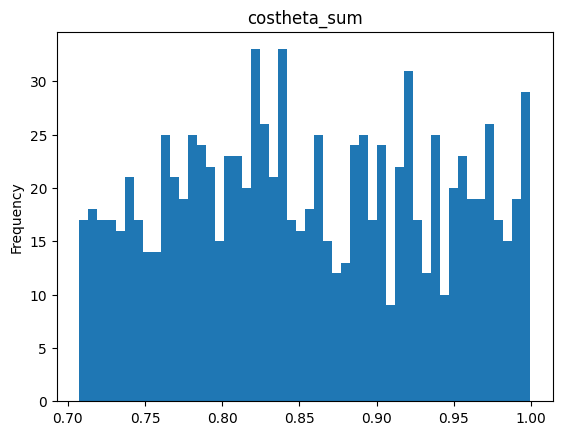

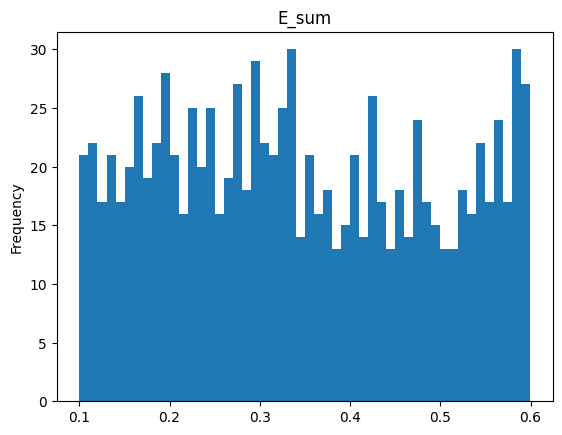

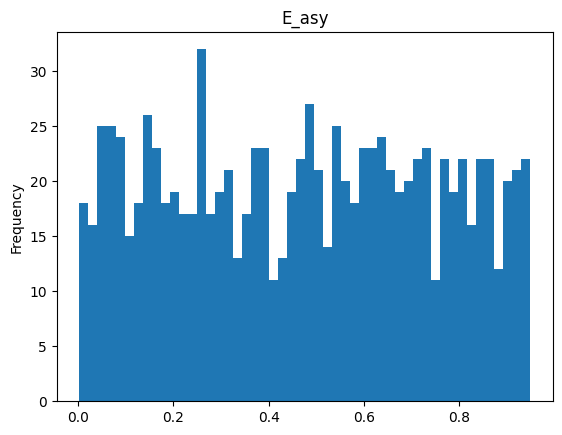

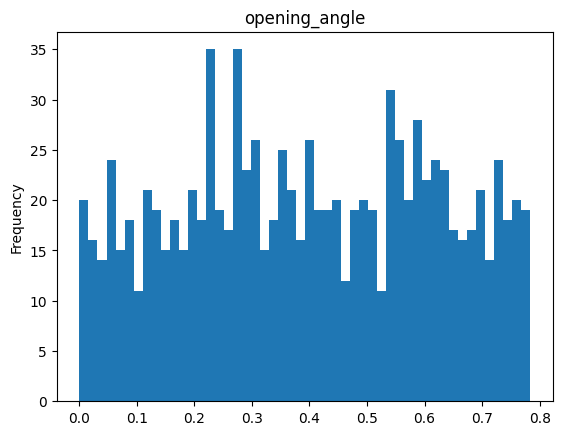

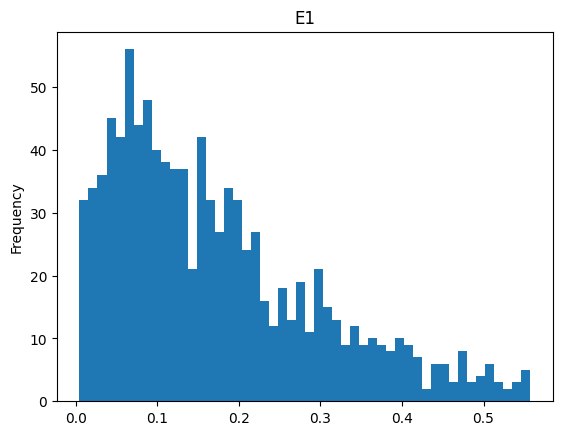

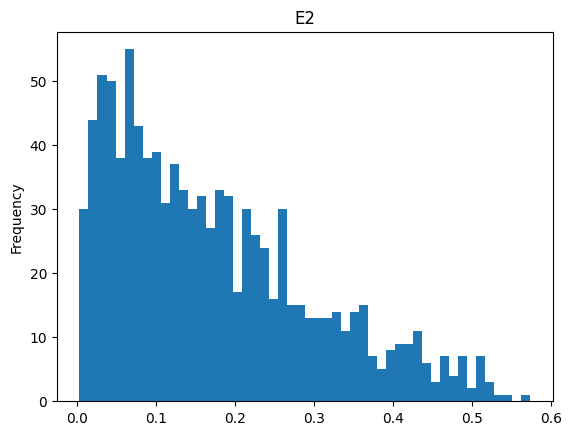

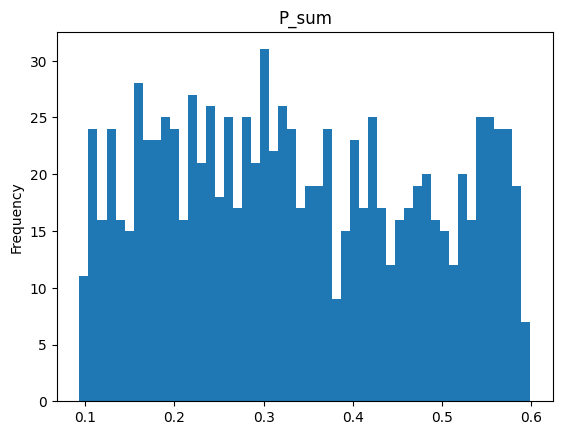

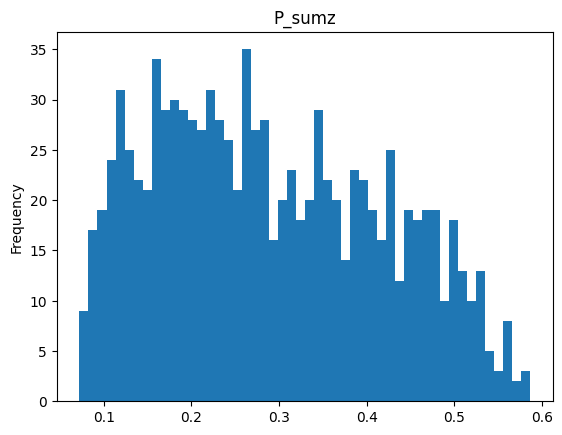

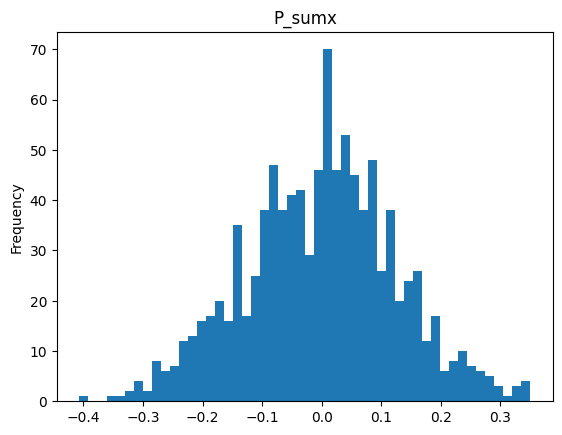

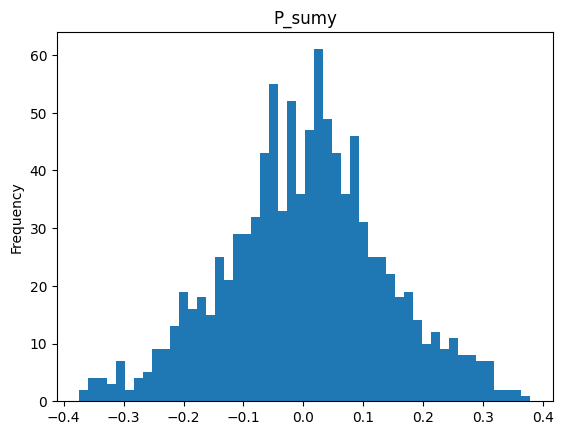

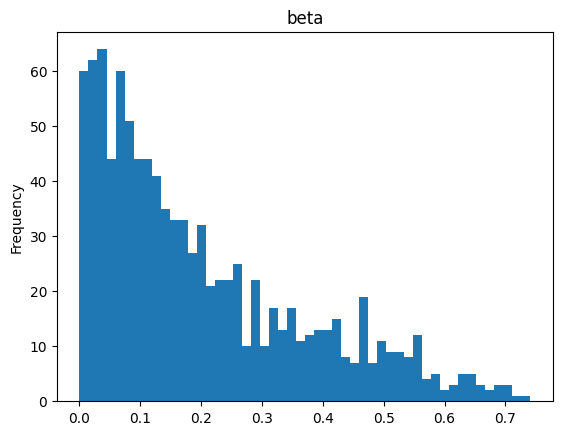

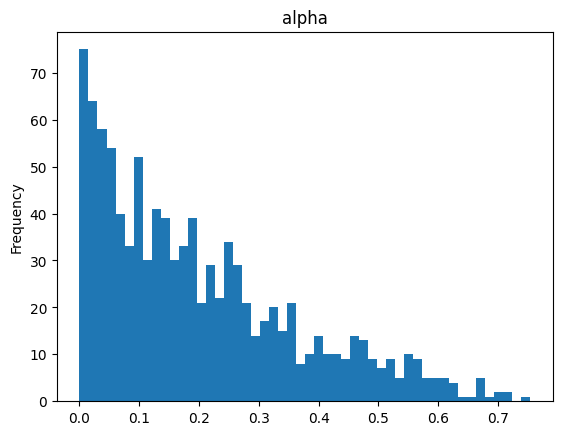

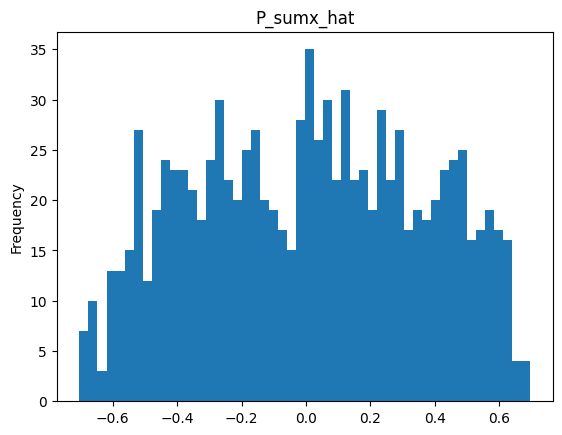

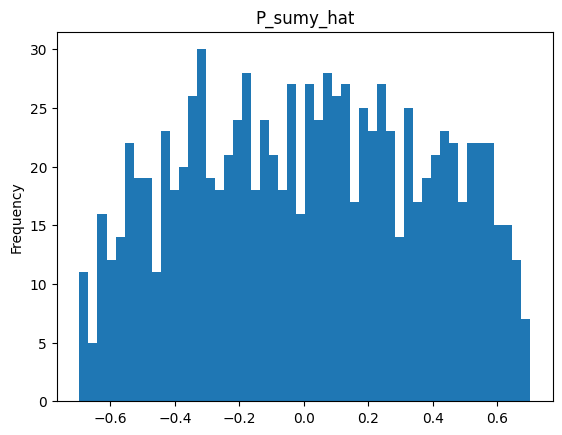

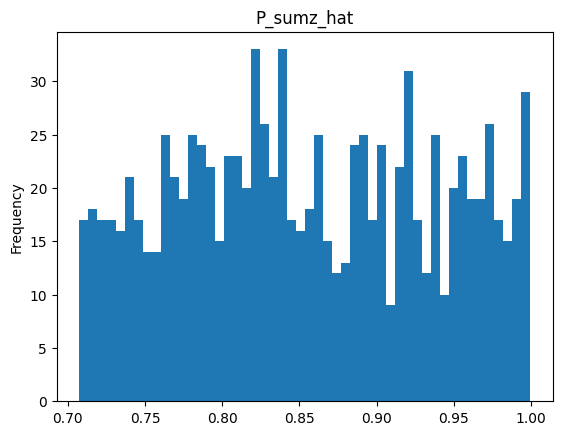

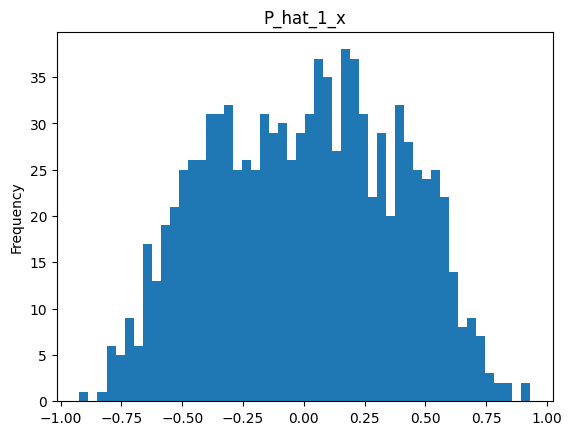

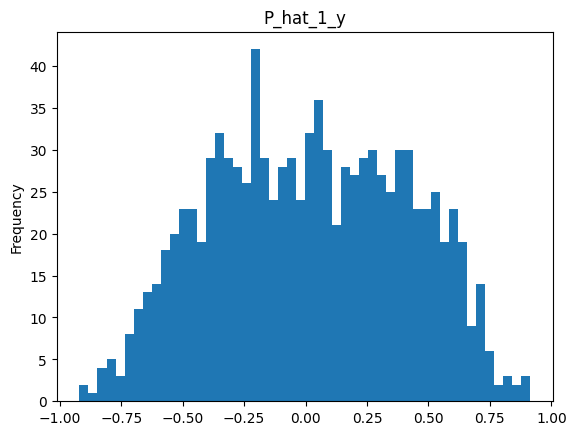

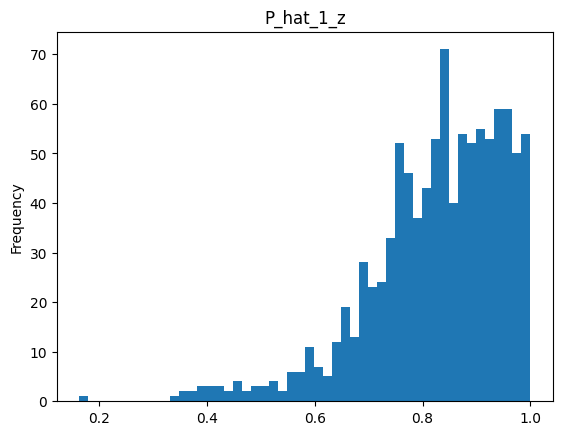

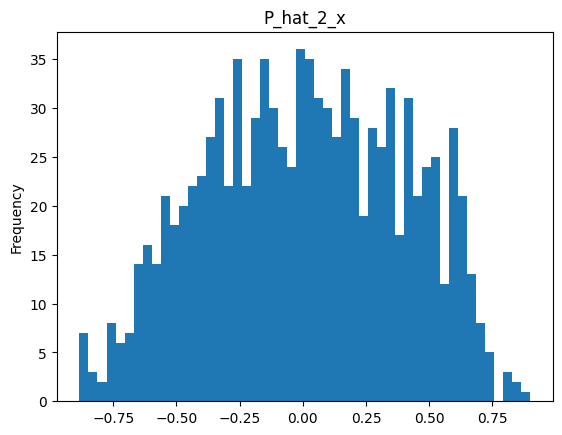

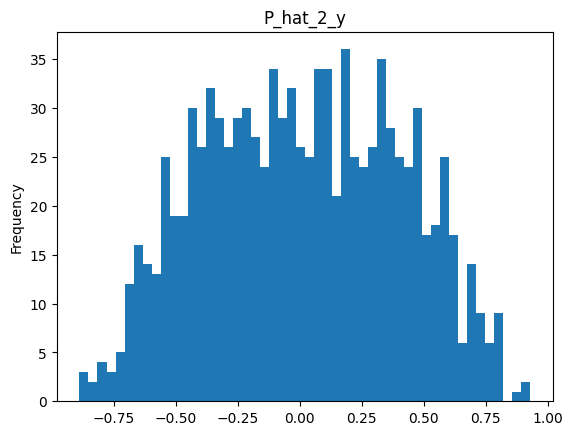

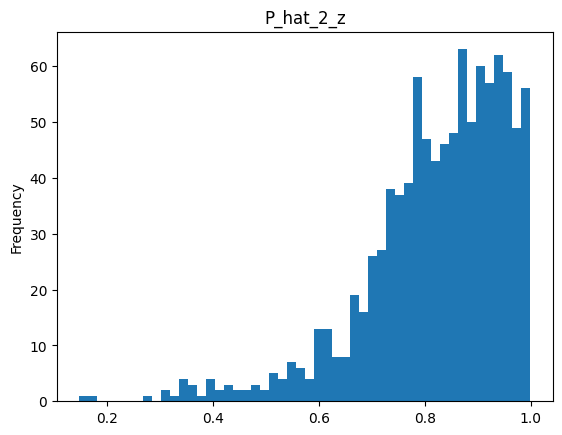

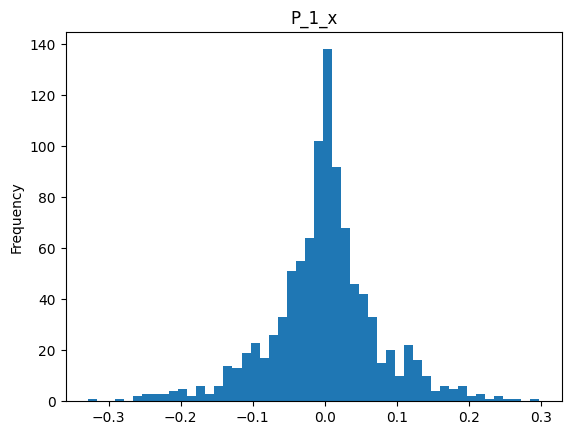

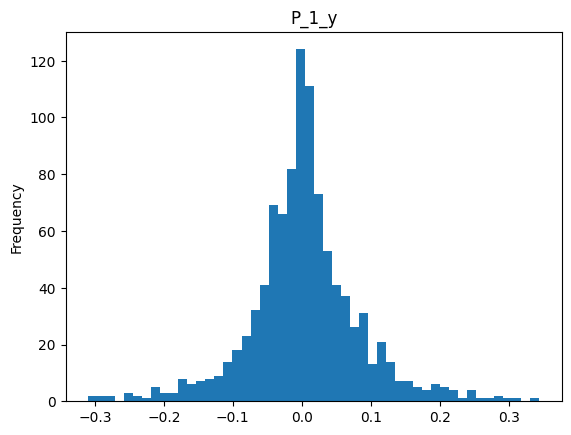

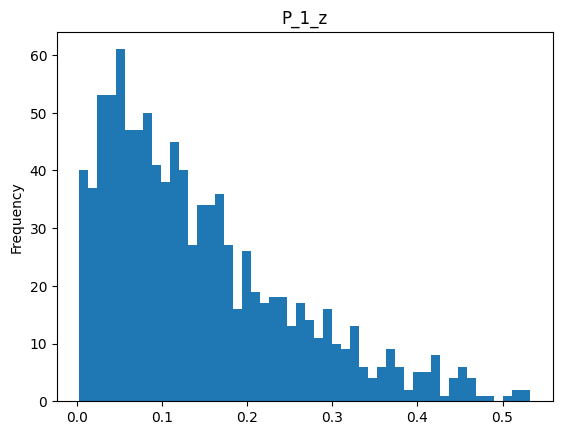

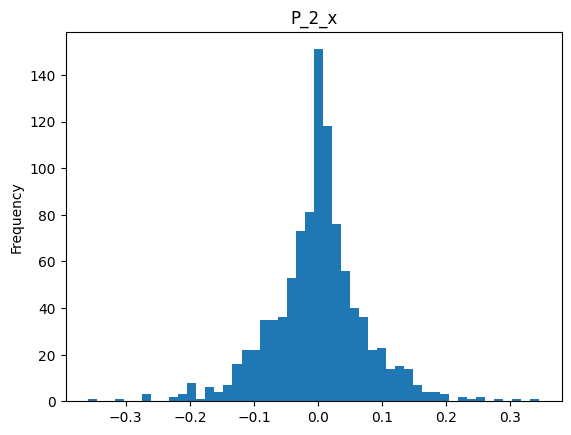

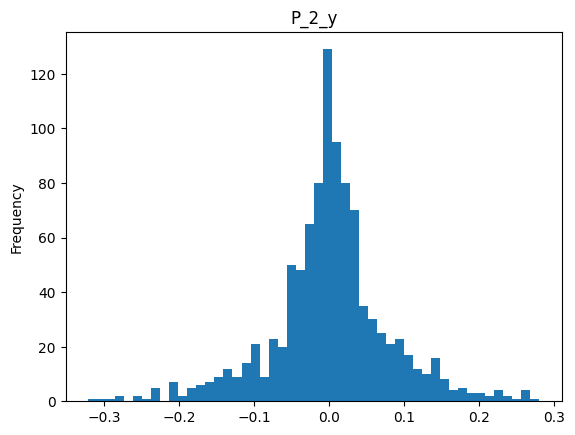

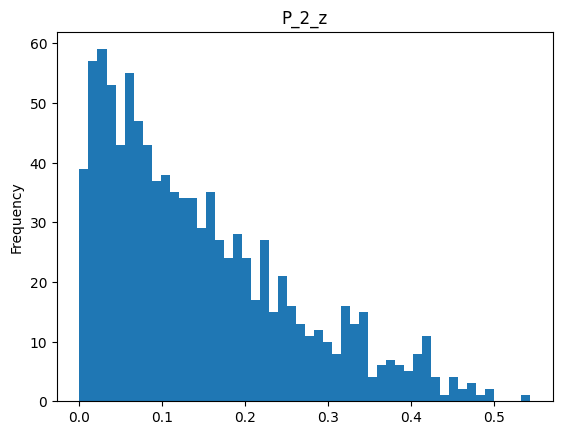

In [8]:
for col in dfg:
    dfg[col].plot(kind='hist',bins=50)
    plt.title(col)
    plt.show()


In [9]:
#Reload from the HEPevt and make a pandas DF
#HEPevt_Isotropic_EpEm_fixed_Pos_Oct2024_v1.1.dat


def read_file_to_df(filename, N1, N2, N3):
    data = []  # List to hold the rows for the DataFrame
    
    with open(filename, 'r') as f:
        lines = f.readlines()
        
        # Process in blocks of 3 lines
        for i in range(0, len(lines), 3):
            if i + 2 < len(lines):  # Ensure there are at least 3 lines in the block
                # Split the lines and extract N1, N2, N3 numbers
                line1 = lines[i].split()[:N1]
                line2 = lines[i + 1].split()[:N2]
                line3 = lines[i + 2].split()[:N3]
                
                # Convert to integers (or floats if needed)
                line1 = [int(num) for num in line1]
                line2 = [float(num) for num in line2]
                line3 = [float(num) for num in line3]
                
                # Combine the extracted numbers into a row
                row = line1 + line2 + line3
                data.append(row)
    
    # Create a DataFrame with columns for each number
    col_names = ["ID","Npart"] + \
                ["id1","pdg1","rnd1","rnd2","rnd3","rnd4","p1x","p1y","p1z","E1","m1","x1","y1","z1","t1"] + \
                ["id2","pdg2","rnd5","rnd6","rnd7","rnd8","p2x","p2y","p2z","E2","m2","x2","y2","z2","t2"]
    df = pd.DataFrame(data, columns=col_names)
    
    return df

# Usage example
filename = 'HEPevt_Isotropic_EpEm_fixed_Pos_Oct2024_v1.1.dat'
N1, N2, N3 = 2, 15, 15  # Adjust as per your requirement
df = read_file_to_df(filename, N1, N2, N3)
df = df.drop(columns=["Npart","id1","id2","rnd1","rnd2","rnd3","rnd4","rnd5","rnd6","rnd7","rnd8","m1","m2"], errors='ignore')  
df['subRunNo']= df['ID'].apply(lambda x: (int)(np.floor(x/50)+1))
df['eventNo']= df['ID'].apply(lambda x: x%50+1)
print(df)
df.to_pickle('HEPevt_Isotropic_EpEm_fixed_Pos_Oct2024_v1.1.pkl')


      ID  pdg1       p1x       p1y       p1z        E1      x1    y1      z1  \
0      0  11.0  0.024588 -0.049300  0.088218  0.104007  126.45  0.97  451.53   
1      1  11.0 -0.100003  0.017265  0.122016  0.158703  126.45  0.97  451.53   
2      2  11.0  0.008285  0.018488  0.045383  0.049700  126.45  0.97  451.53   
3      3  11.0 -0.038530 -0.206965  0.191520  0.284603  126.45  0.97  451.53   
4      4  11.0  0.025009 -0.179439  0.143495  0.231116  126.45  0.97  451.53   
..   ...   ...       ...       ...       ...       ...     ...   ...     ...   
995  995  11.0  0.189376  0.118809  0.264016  0.345953  126.45  0.97  451.53   
996  996  11.0 -0.069130  0.090110  0.098812  0.150541  126.45  0.97  451.53   
997  997  11.0 -0.065649 -0.108728  0.122085  0.176171  126.45  0.97  451.53   
998  998  11.0 -0.002751  0.003055  0.009262  0.010134  126.45  0.97  451.53   
999  999  11.0 -0.328379 -0.015920  0.337952  0.471485  126.45  0.97  451.53   

             t1  ...       p2x       p2

In [10]:

print(df)

      ID  pdg1       p1x       p1y       p1z        E1      x1    y1      z1  \
0      0  11.0  0.024588 -0.049300  0.088218  0.104007  126.45  0.97  451.53   
1      1  11.0 -0.100003  0.017265  0.122016  0.158703  126.45  0.97  451.53   
2      2  11.0  0.008285  0.018488  0.045383  0.049700  126.45  0.97  451.53   
3      3  11.0 -0.038530 -0.206965  0.191520  0.284603  126.45  0.97  451.53   
4      4  11.0  0.025009 -0.179439  0.143495  0.231116  126.45  0.97  451.53   
..   ...   ...       ...       ...       ...       ...     ...   ...     ...   
995  995  11.0  0.189376  0.118809  0.264016  0.345953  126.45  0.97  451.53   
996  996  11.0 -0.069130  0.090110  0.098812  0.150541  126.45  0.97  451.53   
997  997  11.0 -0.065649 -0.108728  0.122085  0.176171  126.45  0.97  451.53   
998  998  11.0 -0.002751  0.003055  0.009262  0.010134  126.45  0.97  451.53   
999  999  11.0 -0.328379 -0.015920  0.337952  0.471485  126.45  0.97  451.53   

             t1  ...       p2x       p2

In [11]:
df = pd.read_pickle('HEPevt_Isotropic_EpEm_fixed_Pos_Oct2024_v1.1.pkl')
df.keys()


Index(['ID', 'pdg1', 'p1x', 'p1y', 'p1z', 'E1', 'x1', 'y1', 'z1', 't1', 'pdg2',
       'p2x', 'p2y', 'p2z', 'E2', 'x2', 'y2', 'z2', 't2', 'subRunNo',
       'eventNo'],
      dtype='object')